In [1]:
import os
import requests
import torch

from src.tokenizer import CharTokenizer

__file__='shakespeare_data/'

# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(__file__), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)


#create the tokenizer
tokenizer=CharTokenizer(input_file_path)
print('tokenizer vocab size:', tokenizer.vocab_size)


length of dataset in characters: 1,115,394
tokenizer vocab size: 65


In [2]:
# load the data
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")


# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = tokenizer(train_data)
val_ids = tokenizer(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
torch.save(train_ids, os.path.join(os.path.dirname(__file__), 'train.bin'))
torch.save(val_ids,   os.path.join(os.path.dirname(__file__), 'val.bin'))

length of dataset in characters: 1,115,394
train has 1,003,854 tokens
val has 111,540 tokens


In [3]:
import torch
from torch import nn
from IPython.display import clear_output

from src.encoder import Encoder, GPT2Encoder
from src.decoder import Decoder, GPT2Decoder
from src.graph_initialization import random_unidirectional_graph_maker, linear_unidirectional_graph_maker
from src.graphAN import GraphAttentionNetwork, BlockGenerator
from src.data_loader import validation
from src.tokenizer import Tokenizer
from src.GPT2 import GPT2_Block, GPT2
from matplotlib import pyplot as plt
from src.utils import moving_average, grad_norm
from torch.nn.utils import clip_grad_norm_
import pickle
import numpy as np


In [4]:
device = 'cpu'
#device = 'mps'  if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

dK = 16
dV = 16
heads = 6
d_Embedding = dK*heads
intermediate_size=intermediate_size=2*d_Embedding


encoder = Encoder(d_Embedding, tokenizer, dropout=0, device=device)
decoder = Decoder(encoder)
block_generator = BlockGenerator(GPT2_Block, d_Embedding, dK, dV, heads, intermediate_size,
                                 dropout=0.1, split_size=2**10, device=device, rotary_encoding=True)

model = GraphAttentionNetwork(tokenizer, encoder, block_generator, decoder)
model.losses = []
model.validation_losses = []
graph_maker = random_unidirectional_graph_maker(50, 50, device=device)

In [5]:
from src.decoder import Loss

loss_function = Loss(decoder)
lr = 8e-4
gamma = 0.99

grad_norms = []

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

In [6]:
from numpy.random import randint
def sample_shakespeare(data, lenght, starting_index=None):
    lenght=int(lenght)
    
    if starting_index is None:
        starting_index = randint(0, len(data)-lenght)

    if starting_index+lenght>=len(data):
        return data[starting_index:]    
    
    return data[starting_index:starting_index+lenght]


Validation loss: 1.64


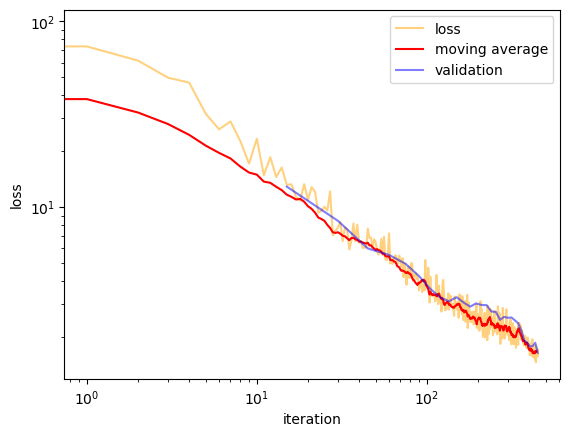

N:195000/1003854, tokens:999, loss:1.70
grad_norm:4.48
N:196000/1003854, tokens:999, loss:1.64
grad_norm:3.10
N:197000/1003854, tokens:999, loss:1.57
grad_norm:3.09
N:198000/1003854, tokens:999, loss:1.62
grad_norm:3.15
N:199000/1003854, tokens:999, loss:1.59
grad_norm:2.89
N:200000/1003854, tokens:999, loss:1.72
grad_norm:3.88
N:201000/1003854, tokens:999, loss:1.60
grad_norm:3.06
N:202000/1003854, tokens:999, loss:1.54
grad_norm:2.83
N:203000/1003854, tokens:999, loss:1.59
grad_norm:2.97
N:204000/1003854, tokens:999, loss:1.65
grad_norm:3.31
N:205000/1003854, tokens:999, loss:1.52


KeyboardInterrupt: 

In [8]:
#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲

n_epochs = int(1e6)
model.train()
context_size=2e2

for i in range(n_epochs):

    
    inp=sample_shakespeare(train_ids, context_size)

    nodes=inp[:-1]
    target=inp[1:]
    edge_index = graph_maker(nodes.shape[0])
    prediction = model(nodes, edge_index)
    loss = loss_function(prediction, target)

    print(f'N:{int(i*1e3)}/{len(train_ids)}, tokens:{nodes.shape[0]}, loss:{loss.item():.2f}')
    model.losses.append(loss.item())
    loss.backward()

    gn = grad_norm(model)
    print(f'grad_norm:{gn:.2f}')
    grad_norms.append(gn)
    clip_grad_norm_(model.parameters(), 4*loss.item())

    optimizer.step()
    optimizer.zero_grad()  # reinitialize the gradient to zero

    if i%15==14:
        clear_output()
        scheduler.step()

        m_av = moving_average(model.losses, 10)
        model.best_loss = min(m_av)

        if model.best_loss<2:
            context_size=1e3

        if model.best_loss<1.5:
            context_size=5e3

        inp=sample_shakespeare(val_ids, 1e3)
        nodes=inp[:-1]
        target=inp[1:]
        edge_index = graph_maker(nodes.shape[0])
        prediction = model(nodes, edge_index)
        validation_loss = loss_function(prediction, target)

        model.validation_losses.append(validation_loss.item())

        print(f'Validation loss: {validation_loss:.2f}')

        plt.plot(model.losses, label='loss', color='orange', alpha=0.5)
        plt.plot(m_av, label='moving average', color='red')
        plt.plot(np.arange(len(model.validation_losses))*15+15, model.validation_losses, label='validation',color='blue',alpha=0.5)

        plt.legend()
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.yscale('log')
        plt.xscale('log')
        plt.show()


In [119]:
text = val_data[:5000]
x=tokenizer(text)

In [118]:
print(val_data)

?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina.

GREMIO:
You are too blunt: go to it orderly.

PETRUCHIO:
You wrong me, Signior Gremio: give me leave.
I am a gentleman of Verona, sir,
That, hearing of her beauty and her wit,
Her affability and bashful modesty,
Her wondrous qualities and mild behavior,
Am bold to show myself a forward guest
Within your house, to make mine eye the witness
Of that report which I so oft have heard.
And, for an entrance to my entertainment,
I do present you with a man of mine,
Cunning in music and the mathematics,
To instruct her fully in those sciences,
Whereof I know she is not ignorant:
Accept of him, or else you do me wrong:
His name is Licio, born in Mantua.

BAPTISTA:
You're welcome, sir; and he, for your good sake.
But for my daughter Katha

In [121]:
target = x[1:]
prediction = x[:-1]

edge_index = graph_maker(prediction.shape[0])

prediction = model(prediction, edge_index)
loss_function(prediction, target)

tensor(1.6985, grad_fn=<NllLossBackward0>)

In [106]:
from torch.nn import Softmax

sm=Softmax(-1)

In [122]:
generated_text=model.generate(text,100,graph_maker)

RuntimeError: shape '[1]' is invalid for input of size 65

In [86]:
print(text)

?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and v


In [87]:
print(generated_text)


?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and ving t went the wing t wen tereee ofereeereeen omeence are allind and and and ane and ane ser sencese
